In [1]:
import geopandas as gpd
from shapely.geometry import Point
import osmnx as ox
import networkx as nx
import shapely
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
stations = gpd.GeoDataFrame(
    {
        "name": [
            "9th Street","7th Street","CTC/Arena","3rd St/Convention",
            "Brooklyn Village","Carson","Bland","East/West"
        ],
        "lat": [35.22970,35.22722,35.22500,35.22361,35.22139,35.21889,35.21583,35.21194],
        "lon": [-80.83500,-80.83806,-80.84139,-80.84306,-80.84694,-80.85083,-80.85528,-80.85917]
    },
    geometry=[Point(xy) for xy in zip([-80.83500,-80.83806,-80.84139,-80.84306,-80.84694,-80.85083,-80.85528,-80.85917],
                                      [35.22970,35.22722,35.22500,35.22361,35.22139,35.21889,35.21583,35.21194])],
    crs="EPSG:4326"
)

In [3]:
# Use stations to define the download area (in meters), then convert back to lat/lon for OSMnx
stations_26917 = stations.to_crs("EPSG:26917")

# Convex hull around stations + buffer so the graph definitely covers South End stations too
download_poly_26917 = stations_26917.union_all().convex_hull.buffer(3000)  # 3000m padding

download_poly_4326 = gpd.GeoSeries([download_poly_26917], crs="EPSG:26917").to_crs("EPSG:4326").iloc[0]

# Download and project graph
G = ox.graph_from_polygon(download_poly_4326, network_type="walk")
G = ox.project_graph(G, to_crs="EPSG:26917")
G = G.to_undirected()

In [4]:
# Getting the area near the station, about a 7-8-minute walk or 600m
distance_m = 600

# stations must be in same CRS as graph for nearest node to work correctly
stations_proj = stations.to_crs("EPSG:26917")

buffers = []

for idx, row in stations_proj.iterrows():
    # IMPORTANT: In projected CRS, use row.geometry.x / y (NOT row.lon/lat)
    u, v, k = ox.nearest_edges(G, row.geometry.x, row.geometry.y)
    # pick whichever endpoint is closer to the station point
    u_pt = Point(G.nodes[u]["x"], G.nodes[u]["y"])
    v_pt = Point(G.nodes[v]["x"], G.nodes[v]["y"])
    node = u if row.geometry.distance(u_pt) <= row.geometry.distance(v_pt) else v

    node_x = G.nodes[node]["x"]
    node_y = G.nodes[node]["y"]

    snap_dist_m = row.geometry.distance(Point(node_x, node_y))
    print(row["name"], "snap distance (m):", round(snap_dist_m, 2))

    subgraph = nx.ego_graph(G, node, radius=distance_m, distance="length")

    nodes, edges = ox.graph_to_gdfs(subgraph)

    # edges are now in meters, so buffer is safe
    polygon = edges.buffer(25).union_all()  # 25 meters

    buffers.append(polygon)

    print(row["name"], subgraph.number_of_nodes(), subgraph.number_of_edges())


stations_walkshed = stations_proj.copy()
stations_walkshed["geometry"] = buffers

# If you want it back in lat/lon for export/maps:
stations_walkshed_4326 = stations_walkshed.to_crs("EPSG:4326")

9th Street snap distance (m): 29.76
9th Street 1060 1581
7th Street snap distance (m): 38.08
7th Street 1042 1551
CTC/Arena snap distance (m): 45.81
CTC/Arena 1227 1823
3rd St/Convention snap distance (m): 26.36
3rd St/Convention 1264 1855
Brooklyn Village snap distance (m): 42.1
Brooklyn Village 727 1046
Carson snap distance (m): 54.77
Carson 263 364
Bland snap distance (m): 8.96
Bland 761 1091
East/West snap distance (m): 31.89
East/West 1060 1528


In [5]:
# Saving the walking areas to a GeoJSON file
stations_walkshed.to_file("data\station_walksheds.geojson", driver="GeoJSON")

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Jason\AppData\Local\Temp\ipykernel_35828\1000055398.py:2: SyntaxWarning: invalid escape sequence '\s'
  stations_walkshed.to_file("data\station_walksheds.geojson", driver="GeoJSON")


In [6]:
# Part 2: Filtering CMPD Crime data to within walking radius of stations
crime_df = pd.read_csv("data\cmpd_cleaned_with_clusters.csv")
#crime_df = pd.read_csv(r"C:\Users\Jason\Downloads\CMPD_Incidents.csv")
crime_gdf = gpd.GeoDataFrame(
    crime_df,
    geometry=gpd.points_from_xy(crime_df["LONGITUDE_PUBLIC"], crime_df["LATITUDE_PUBLIC"]),
    crs="EPSG:4326"
)
crime_gdf = crime_gdf.to_crs("EPSG:4326")
stations_walkshed = stations_walkshed_4326
print(crime_df.shape)

<>:2: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Jason\AppData\Local\Temp\ipykernel_35828\736270669.py:2: SyntaxWarning: invalid escape sequence '\c'
  crime_df = pd.read_csv("data\cmpd_cleaned_with_clusters.csv")


(531593, 13)


In [7]:
crime_filtered = gpd.sjoin(
    crime_gdf,
    stations_walkshed,
    predicate="within",
    how="inner"
)
print(crime_filtered.shape)

(43757, 18)


In [8]:
crime_filtered['cluster_title'].value_counts()

cluster_title
"Regulatory and Non-Violent Offenses"    15207
Theft and Vehicle Offenses               14998
"Violent and Public Safety Offenses"      4705
"Coercive and Violent Offenses"           2794
Fraud and Financial Crimes                2184
"Theft-Related Offenses"                  1570
Sexual Exploitation Crimes                 881
"Fatal Incidents and Investigations"       879
Sexual Assault Crimes                      538
Sexual and Gambling Offenses                 1
Name: count, dtype: int64

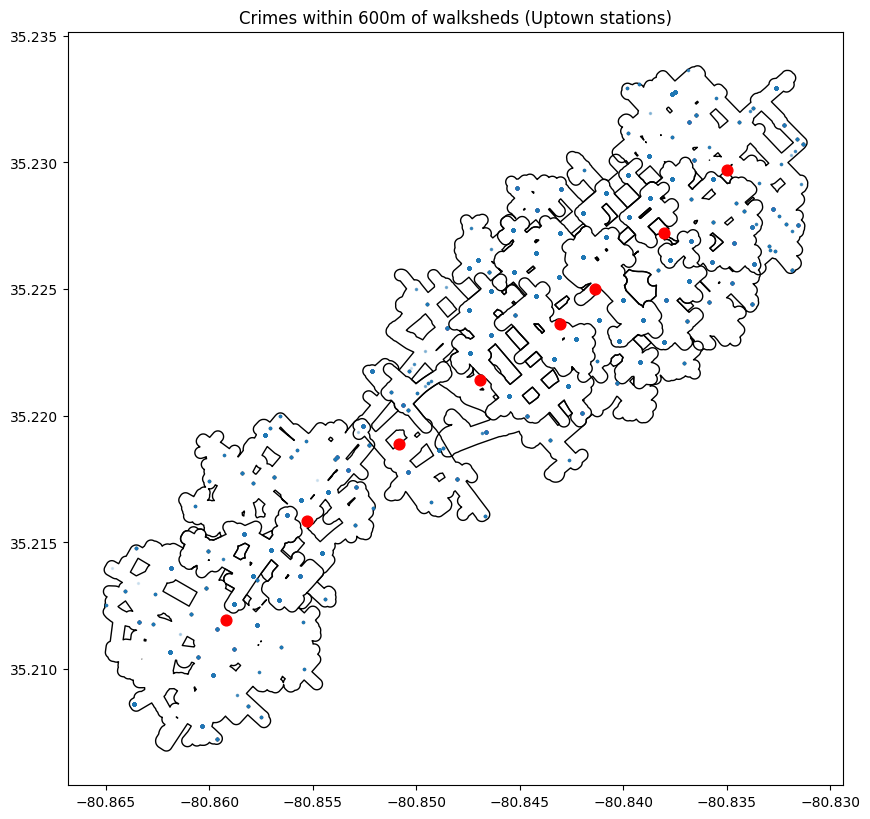

In [9]:
stations_4326 = stations.to_crs("EPSG:4326")   # ensure stations in lat/lon
crime_4326 = crime_filtered.to_crs("EPSG:4326")  # ensure crimes in lat/lon

fig, ax = plt.subplots(figsize=(10,10))

# walksheds as outlines (not filled), so they don't hide points
stations_walkshed_4326.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1, zorder=1)

# crimes: tiny + transparent so overlaps show up as darker areas
crime_4326.plot(ax=ax, markersize=2, alpha=0.15, zorder=2)

# stations: bigger and on top
stations_4326.plot(ax=ax, markersize=60, color="red", zorder=3)

ax.set_title("Crimes within 600m of walksheds (Uptown stations)")
plt.show()

In [10]:
crime_filtered.to_csv("data\\crime_within_station_walksheds.csv", index=False)